In [47]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import stats
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import test.utils as test2

In [2]:
scv.set_figure_params(dpi=100, color_map = 'viridis_r')
scv.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.8.0 umap==0.4.1 numpy==1.19.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9


In [3]:
# read UMI counts and params for c57 and cast viariants
UMI_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.csv', index_col=0)
UMI_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.csv', index_col=0)

UMI = UMI_c57 + UMI_cast

# transpose to ge n_cells x n_genes shape
UMI_c57_T = UMI_c57.transpose(copy=True)
UMI_cast_T = UMI_cast.transpose(copy=True)
UMI_T = UMI.transpose(copy=True)

adata = ad.AnnData(UMI_T)
adata.layers['spliced'] = UMI_c57_T
adata.layers['unspliced'] = UMI_cast_T

gtf = pd.read_csv("data/Mus_musculus.GRCm38.102.chr.gtf", sep='\t', skiprows=5, header=None)
gtf.columns = ['chr', 'database', 'type', 'start', 'end', '.', 'strand', '.', 'other']
gtf = gtf[gtf['type'] == "gene"]
gtf = gtf.reset_index()

dic_gene_names = {}
index = 0
for line in gtf['other'].tolist():
    line = line.split(';')
    dic_gene_names[line[0][9:-1]]= [gtf['chr'][index], line[2][12:-1]]
    index += 1
    
adata.var['gene_name'] = [dic_gene_names[x][1] if x in dic_gene_names.keys() else 'NA' for x in adata.var.index]
adata.var['chromosome'] = [dic_gene_names[x][0] if x in dic_gene_names.keys() else 'NA' for x in adata.var.index]


label = []
for chrom in adata.var['chromosome']:
    if chrom == "X":
        label.append('X')
    elif chrom == "Y":
        label.append('Y')
    else:
        label.append('autosome')
adata.var['autosomes'] = label

label = []
for chrom in adata.var['chromosome']:
    if chrom == "MT":
        label.append('MT')
    else:
        label.append('nuclear')
adata.var['nuclear'] = label

label = []
for genes in adata.var['gene_name']:
    if genes[:2]=='Rp':
        label.append('Ribosomal protein')
    else:
        label.append('other protein')
adata.var['Ribosomal_prot'] = label

test.remove_na(adata)
test.find_ratios_sum(adata)
test.find_ratios_std(adata)

sc.pp.neighbors(adata, n_neighbors=8, n_pcs=31)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata.obs['clusters'] = adata.obs['leiden'].copy()

adata
                           
                           

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 682 × 3134
    obs: 'leiden', 'clusters'
    var: 'gene_name', 'chromosome', 'autosomes', 'nuclear', 'Ribosomal_prot', 'sum_allele_1', 'sum_allele_2', 'ratio_allele_1', 'ratio_allele_2', 'ratio_sum_allele_1', 'ratio_sum_allele_2', 'ratio_mean_allele_1', 'ratio_mean_allele_2', 'ratio_std_allele_1', 'ratio_std_allele_2'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'ratio_allele_1', 'ratio_allele_2'
    obsp: 'distances', 'connectivities'

<AxesSubplot:xlabel='ratio_allele_1', ylabel='Density'>

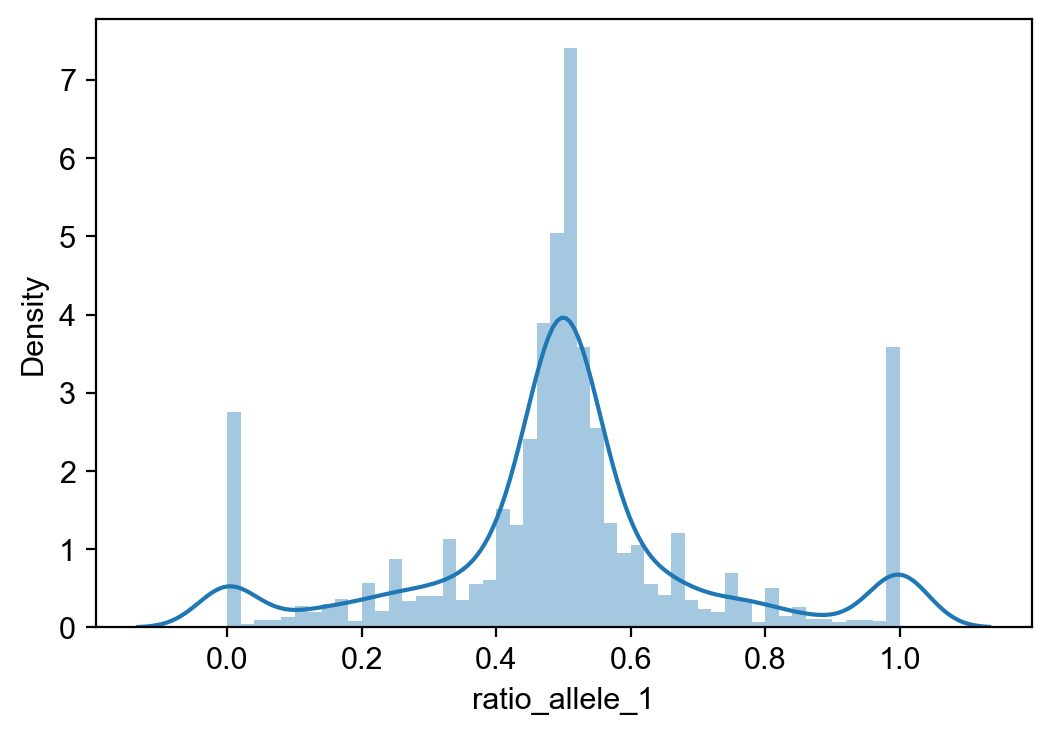

In [4]:
sns.distplot(adata.var.ratio_allele_1)

<AxesSubplot:xlabel='ratio_allele_2', ylabel='Density'>

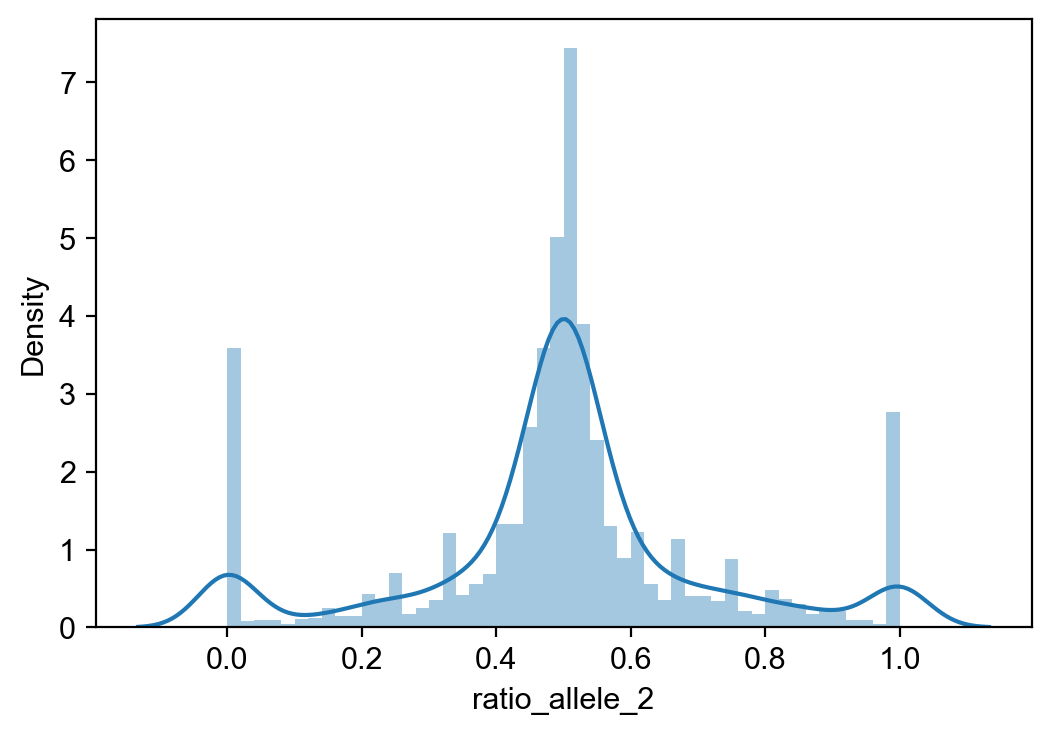

In [14]:
sns.distplot(adata.var.ratio_allele_2)

In [11]:
stats.ks_2samp(adata.var.ratio_allele_1, adata.var.ratio_allele_2)

KstestResult(statistic=0.018825781748564134, pvalue=0.6352911372540528)

In [13]:
stats.ks_2samp(np.log(adata.var.ratio_allele_1), np.log(adata.var.ratio_allele_2))

KstestResult(statistic=0.018825781748564134, pvalue=0.6352911372540528)

In [6]:
stats.ks_2samp(adata.var.sum_allele_1, adata.var.sum_allele_2)

KstestResult(statistic=0.0204211869814933, pvalue=0.5306407660670365)

In [7]:
stats.ks_2samp(adata.var.ratio_sum_allele_1, adata.var.ratio_sum_allele_2)

KstestResult(statistic=0.02169751116783663, pvalue=0.45195403786722044)

In [8]:
stats.ks_2samp(adata.var.ratio_mean_allele_1, adata.var.ratio_mean_allele_2)

KstestResult(statistic=0.018825781748564134, pvalue=0.6352911372540528)

In [9]:
stats.ks_2samp(adata.var.ratio_std_allele_1, adata.var.ratio_std_allele_2)

KstestResult(statistic=0.0012763241863433313, pvalue=1.0)

In [24]:
a1 = adata.layers['spliced'][:,1]

In [23]:
a2 = adata.layers['unspliced'][:,1]

In [36]:
test = stats.ks_2samp(a1, a2)

0.007331378299120235

In [27]:
x,y = adata.shape

In [43]:
p_list = []
for n in range(0, y):
    a = adata.layers['spliced'][:,n]
    b = adata.layers['unspliced'][:,n]
    test = stats.ks_2samp(a, b)
#     if test[1] < 0.05:
    p_list.append(test[1])
    
    
len(p_list)
    

3134

<AxesSubplot:ylabel='Density'>

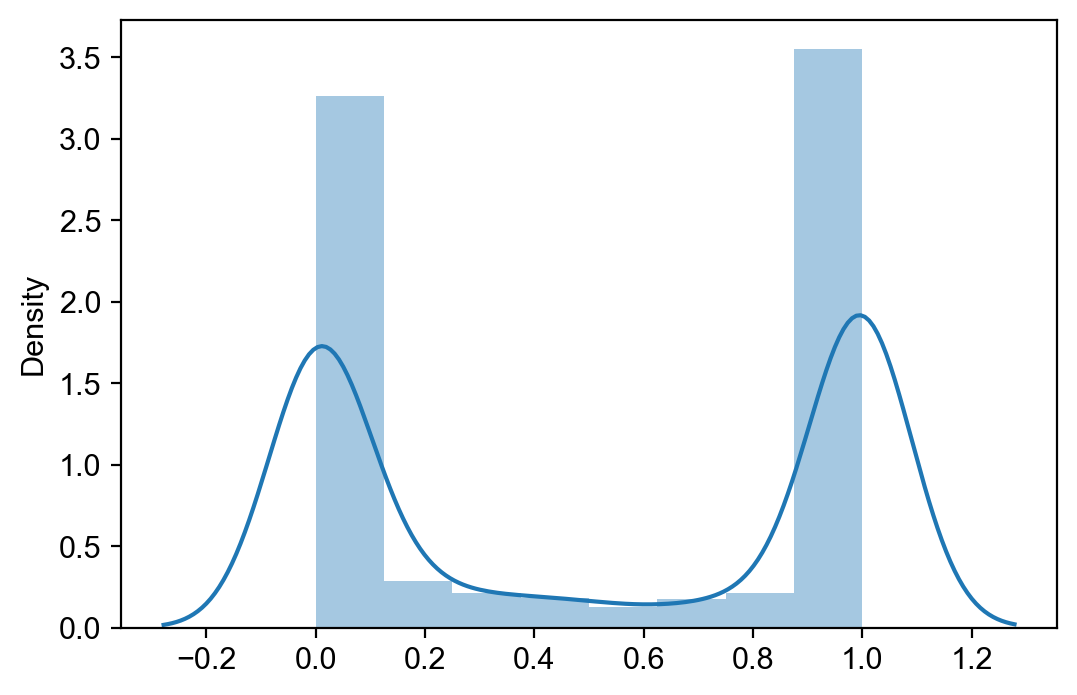

In [44]:
sns.distplot(p_list)

In [45]:
adata.var['p_value'] = p_list

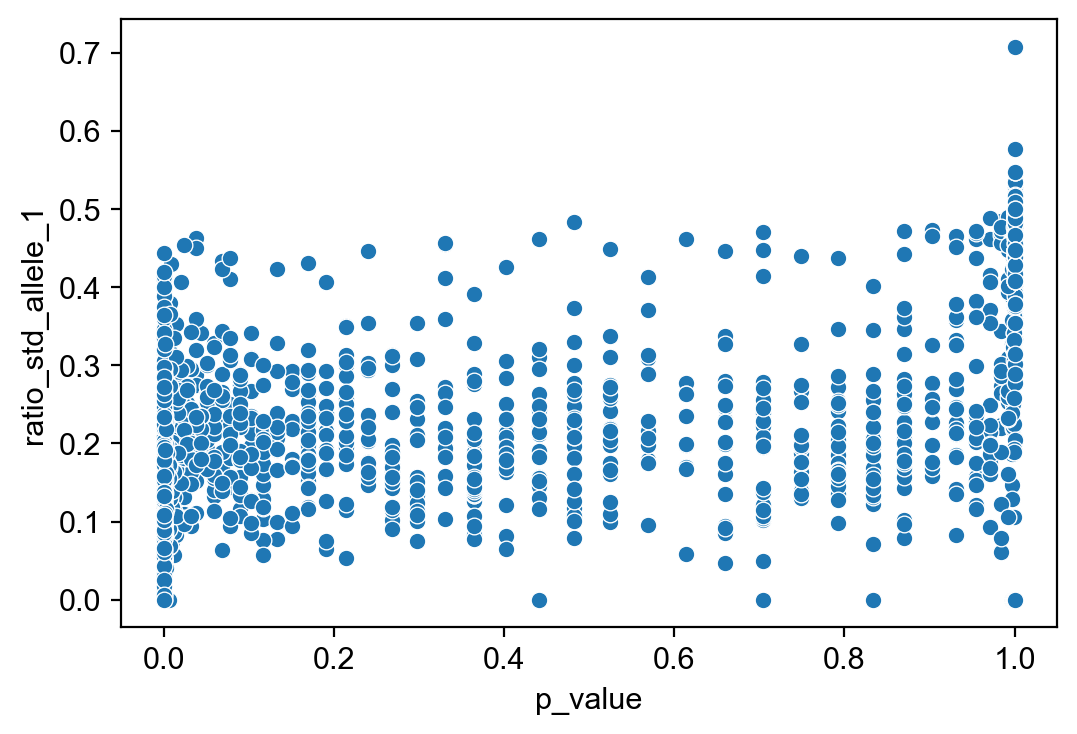

In [49]:
test2.sns_scatter(x="p_value", y="ratio_std_allele_1", data=adata.var)

In [53]:
print(adata.var.gene_name[0:10].tolist())

['Gnai3', 'Apoh', 'Cox5a', 'Ngfr', 'Ccnd2', 'Hddc2', 'Cdh1', 'Comt', 'Rtca', 'Dazap2']


In [10]:
# import random
# data1 = random.sample(list(adata.var.ratio_allele_1), 1000)
# data2 = random.sample(list(adata.var.ratio_allele_2), 1000)
# stats.ks_2samp(data1, data2)

In [34]:
adata.layers['ratio_allele_1']

array([[0.71428571,        nan, 0.58823529, ...,        nan,        nan,
               nan],
       [0.25      , 1.        , 0.78571429, ...,        nan,        nan,
               nan],
       [0.31428571,        nan, 0.65217391, ...,        nan,        nan,
               nan],
       ...,
       [0.57142857,        nan, 0.28571429, ...,        nan,        nan,
               nan],
       [0.5625    ,        nan, 0.        , ...,        nan,        nan,
               nan],
       [0.58333333,        nan, 0.66666667, ...,        nan,        nan,
               nan]])